In [ ]:
# В общем, не получилось

Epoch 0, Train Loss: 293.0656, Val Loss: 0.4070
Epoch 1, Train Loss: 209.7125, Val Loss: 0.4222
Epoch 2, Train Loss: 202.1024, Val Loss: 0.3871
Epoch 3, Train Loss: 193.9008, Val Loss: 0.5984
Epoch 4, Train Loss: 193.8690, Val Loss: 0.7164
Epoch 5, Train Loss: 187.3043, Val Loss: 0.5088
Epoch 6, Train Loss: 185.7939, Val Loss: 0.3381
Epoch 7, Train Loss: 183.6774, Val Loss: 0.3316
Epoch 8, Train Loss: 182.1913, Val Loss: 0.3518
Epoch 9, Train Loss: 182.5540, Val Loss: 0.4517
Epoch 10, Train Loss: 182.2056, Val Loss: 0.4945
Epoch 11, Train Loss: 180.7298, Val Loss: 0.4645
Epoch 12, Train Loss: 178.2321, Val Loss: 0.3643
Epoch 13, Train Loss: 180.6308, Val Loss: 0.7142
Epoch 14, Train Loss: 168.6661, Val Loss: 0.4937
Epoch 15, Train Loss: 172.1007, Val Loss: 0.3319
Epoch 16, Train Loss: 164.8031, Val Loss: 0.6039
Epoch 17, Train Loss: 168.6046, Val Loss: 0.3326
Epoch 18, Train Loss: 168.7787, Val Loss: 0.3252
Epoch 19, Train Loss: 166.2739, Val Loss: 0.6539
Epoch 20, Train Loss: 167.9007

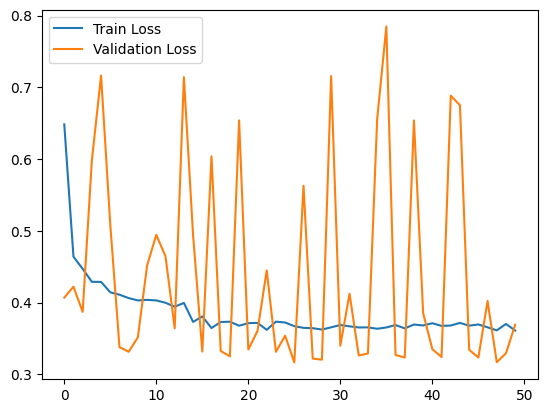

Test Loss: 0.3172


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Загружаем данные
data = fetch_california_housing()
X, y = data.data, data.target.reshape(-1, 1)  # Мультирегрессия: y имеет несколько выходов

# Разделяем данные
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Нормализация
scaler = StandardScaler()
X_train, X_val, X_test = scaler.fit_transform(X_train), scaler.transform(X_val), scaler.transform(X_test)

# Преобразуем в тензоры
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# Маленькая модель FCNN
class SmallFCNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SmallFCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, output_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# Функция обучения
def train_model(model, train_loader, val_loader, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
    loss_fn = nn.MSELoss()

    train_losses, val_losses = [], []
    best_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = validate_model(model, val_loader, loss_fn)
        scheduler.step(val_loss)

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Функция валидации
def validate_model(model, val_loader, loss_fn):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            preds = model(x_batch)
            loss = loss_fn(preds, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Функция тестирования
def test_model(model, test_loader):
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    test_loss = 0
    loss_fn = nn.MSELoss()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            preds = model(x_batch)
            loss = loss_fn(preds, y_batch)
            test_loss += loss.item()
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# Визуализация
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.show()

# Обучаем модель
input_size = X_train.shape[1]
output_size = y_train.shape[1]

model = SmallFCNN(input_size, output_size)
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=50)

# Графики
plot_losses(train_losses, val_losses)

# Тестирование
test_model(model, test_loader)

Epoch 1: Train Loss: 0.6002, Val Loss: 0.6472
Epoch 2: Train Loss: 0.4807, Val Loss: 0.4399
Epoch 3: Train Loss: 0.4614, Val Loss: 0.4393
Epoch 4: Train Loss: 0.4458, Val Loss: 0.3820
Epoch 5: Train Loss: 0.4308, Val Loss: 0.3956
Epoch 6: Train Loss: 0.4369, Val Loss: 0.6184
Epoch 7: Train Loss: 0.4210, Val Loss: 0.3673
Epoch 8: Train Loss: 0.4106, Val Loss: 0.3663
Epoch 9: Train Loss: 0.4228, Val Loss: 0.5224
Epoch 10: Train Loss: 0.4094, Val Loss: 0.3498
Epoch 11: Train Loss: 0.3856, Val Loss: 0.3580
Epoch 12: Train Loss: 0.3810, Val Loss: 0.4168
Epoch 13: Train Loss: 0.3793, Val Loss: 0.3857
Epoch 14: Train Loss: 0.3804, Val Loss: 0.3369
Epoch 15: Train Loss: 0.3739, Val Loss: 0.6557
Epoch 16: Train Loss: 0.3752, Val Loss: 0.4257
Epoch 17: Train Loss: 0.3735, Val Loss: 0.6041
Epoch 18: Train Loss: 0.3709, Val Loss: 0.5834
Epoch 19: Train Loss: 0.3713, Val Loss: 0.3212
Epoch 20: Train Loss: 0.3699, Val Loss: 0.3256
Epoch 21: Train Loss: 0.3654, Val Loss: 0.3902
Epoch 22: Train Loss: 

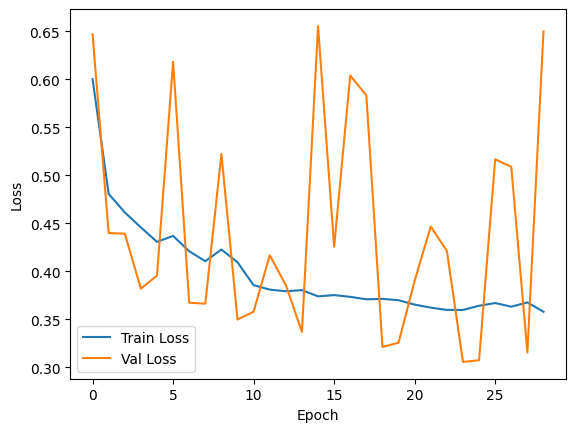

Test Loss: 0.6330


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# === 1. Подготовка данных ===
data = fetch_california_housing()
X, y = data.data, data.target.reshape(-1, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train, X_val, X_test = scaler.fit_transform(X_train), scaler.transform(X_val), scaler.transform(X_test)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# === 2. Определение модели ===
class MediumFCNN(nn.Module):
    def __init__(self, input_dim):
        super(MediumFCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# === 3. Настройка обучения ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MediumFCNN(X_train.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# === 4. Функция тренировки ===
def train_model(model, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        scheduler.step()

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses

# === 5. Запуск тренировки ===
model, train_losses, val_losses = train_model(model, criterion, optimizer, scheduler)

# === 6. Визуализация ===
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# === 7. Оценка на тесте ===
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Epoch 1/200 | Train Loss: 0.8060 | Val Loss: 0.4550
Epoch 2/200 | Train Loss: 0.4600 | Val Loss: 0.4068
Epoch 3/200 | Train Loss: 0.4211 | Val Loss: 0.3606
Epoch 4/200 | Train Loss: 0.4027 | Val Loss: 0.5545
Epoch 5/200 | Train Loss: 0.3823 | Val Loss: 0.4807
Epoch 6/200 | Train Loss: 0.3805 | Val Loss: 0.4093
Epoch 7/200 | Train Loss: 0.3676 | Val Loss: 0.3465
Epoch 8/200 | Train Loss: 0.3702 | Val Loss: 0.5353
Epoch 9/200 | Train Loss: 0.3582 | Val Loss: 0.7016
Epoch 10/200 | Train Loss: 0.3496 | Val Loss: 0.7010
Epoch 11/200 | Train Loss: 0.3506 | Val Loss: 0.4931
Epoch 12/200 | Train Loss: 0.3448 | Val Loss: 0.8077
Epoch 13/200 | Train Loss: 0.3425 | Val Loss: 0.7024
Epoch 14/200 | Train Loss: 0.3411 | Val Loss: 0.3080
Epoch 15/200 | Train Loss: 0.3322 | Val Loss: 0.6567
Epoch 16/200 | Train Loss: 0.3298 | Val Loss: 0.3056
Epoch 17/200 | Train Loss: 0.3246 | Val Loss: 0.3927
Epoch 18/200 | Train Loss: 0.3276 | Val Loss: 0.2964
Epoch 19/200 | Train Loss: 0.3284 | Val Loss: 0.3239
Ep

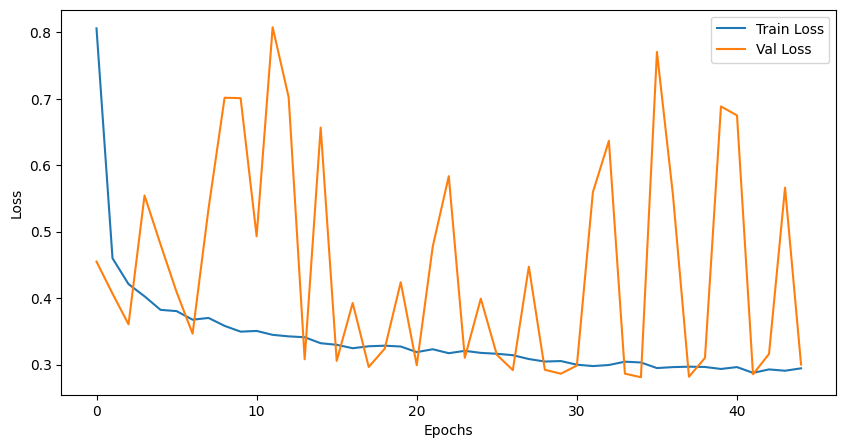

Test Loss: 0.2621


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# === 1. Подготовка данных ===
data = fetch_california_housing()
X, y = data.data, data.target.reshape(-1, 1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val, X_test = scaler.transform(X_val), scaler.transform(X_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

# === 2. Архитектура модели ===
class DeepFCNN(nn.Module):
    def __init__(self, input_dim):
        super(DeepFCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

model = DeepFCNN(X_train.shape[1]).to(device)

# === 3. Функция потерь, оптимизатор, шедулер ===
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# === 4. Обучение модели ===
num_epochs = 200
patience = 10
best_loss = float('inf')
best_model = None
train_losses, val_losses = [], []
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Валидация
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Сохраняем лучшую модель
torch.save(best_model, "best_model.pth")

# === 5. Графики ===
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# === 6. Оценка на тесте ===
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        test_loss += criterion(y_pred, y_batch).item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")
